In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
df = pd.read_csv("drug_dependent_population_balanced.csv")

In [ ]:
# Preprocess the data
label_encoders = {}
for column in ['Gender', 'Drug_Type', 'Frequency_of_Use', 'Mental_Health_Status', 'Employment_Status', 'Social_Support']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

X = df.drop(columns=['Verified'])
y = df['Verified']

# Add noise to numerical features
numerical_cols = X.select_dtypes(include=[np.number]).columns
X[numerical_cols] += np.random.normal(0, 0.1, X[numerical_cols].shape)

# Create random outliers
num_outliers = int(0.05 * X.shape[0])
outliers = np.random.uniform(low=-1, high=1, size=(num_outliers, X.shape[1]))
outlier_labels = np.random.randint(0, 2, size=num_outliers)

X_with_outliers = np.vstack([X, outliers])
y_with_outliers = np.concatenate([y, outlier_labels])

# Shuffle the dataset
df_with_outliers = pd.DataFrame(X_with_outliers, columns=X.columns)
df_with_outliers['Verified'] = y_with_outliers
df_shuffled = df_with_outliers.sample(frac=1, random_state=42).reset_index(drop=True)

X_shuffled = df_shuffled.drop(columns=['Verified'])
y_shuffled = df_shuffled['Verified']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [5]:
# Hyperparameter tuning for RandomForest
rf_model = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(rf_model, rf_params, cv=5)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Hyperparameter tuning for XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'learning_rate': [0.01, 0.1]}
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_


In [6]:
# More complex neural network model
nn_model = Sequential()
nn_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

# Compile the neural network with a higher initial learning rate
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Adjusting training settings for faster start
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the neural network with fewer epochs for a faster start
nn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stopping], verbose=1)


C:\Users\gulig\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7729 - loss: 0.4613 - val_accuracy: 0.8469 - val_loss: 0.2965
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8731 - loss: 0.2793 - val_accuracy: 0.9082 - val_loss: 0.2102
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8841 - loss: 0.2392 - val_accuracy: 0.9067 - val_loss: 0.1931
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8880 - loss: 0.2264 - val_accuracy: 0.9155 - val_loss: 0.1819
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8995 - loss: 0.2085 - val_accuracy: 0.9227 - val_loss: 0.1554
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9076 - loss: 0.1826 - val_accuracy: 0.9213 - val_loss: 0.1614
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9075 - loss: 0.1949 - val_accuracy: 0.9344 - val_loss: 0.1496
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9096 - loss: 0.1895 - val_accuracy: 0.9213 - val_loss:

In [7]:
# Make predictions
rf_pred = best_rf.predict(X_test)
xgb_pred = best_xgb.predict(X_test)
nn_pred = (nn_model.predict(X_test) > 0.5).astype(int).flatten()  # Flatten to match the shape of y_test

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return accuracy, precision, recall, f1, rmse

models = {
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred,
    'Neural Network': nn_pred,
}

metrics = {}
for model_name, predictions in models.items():
    metrics[model_name] = calculate_metrics(y_test, predictions)

# Create DataFrame for metrics
metrics_df = pd.DataFrame(metrics).T
metrics_df.reset_index(inplace=True)
metrics_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'RMSE']

# Print metrics
print(metrics_df)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
            Model  Accuracy  Precision    Recall  F1 Score      RMSE
0   Random Forest  0.977843   0.977435  0.977435  0.977435  0.148854
1         XGBoost  0.973761   0.972716  0.973872  0.973294  0.161985
2  Neural Network  0.933528   0.887234  0.990499  0.936027  0.257822


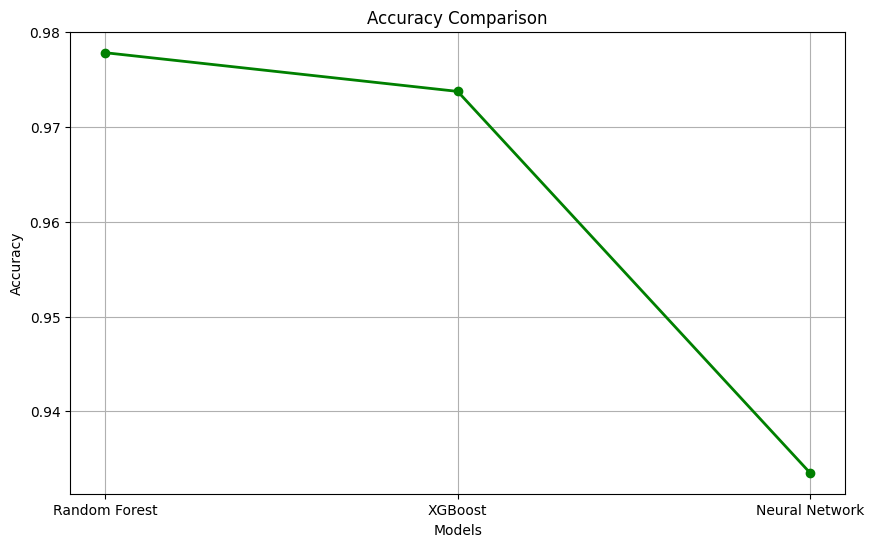

In [8]:
# Line Chart for Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Model'], metrics_df['Accuracy'], marker='o', color='green', linestyle='-', linewidth=2)
plt.title('Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


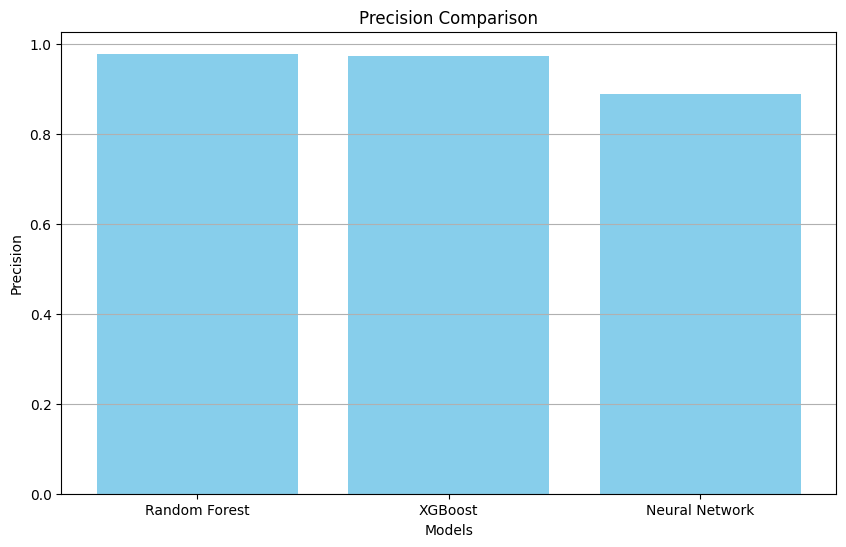

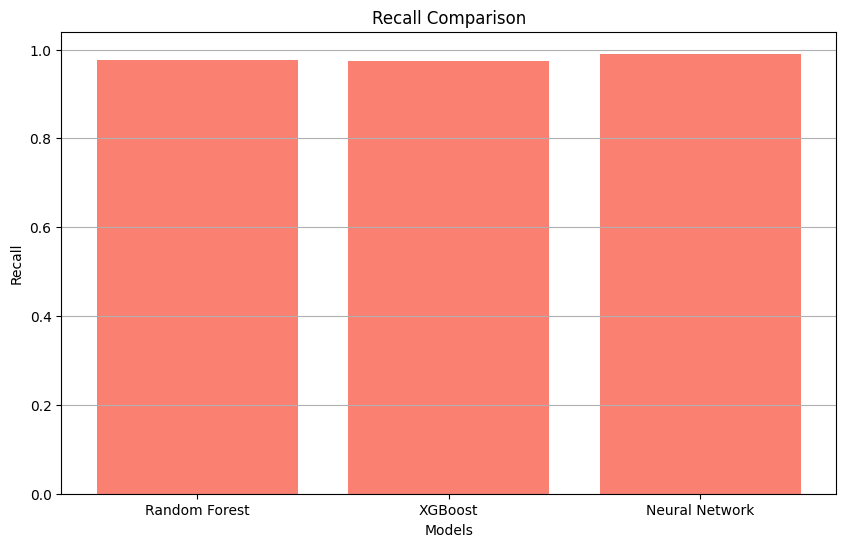

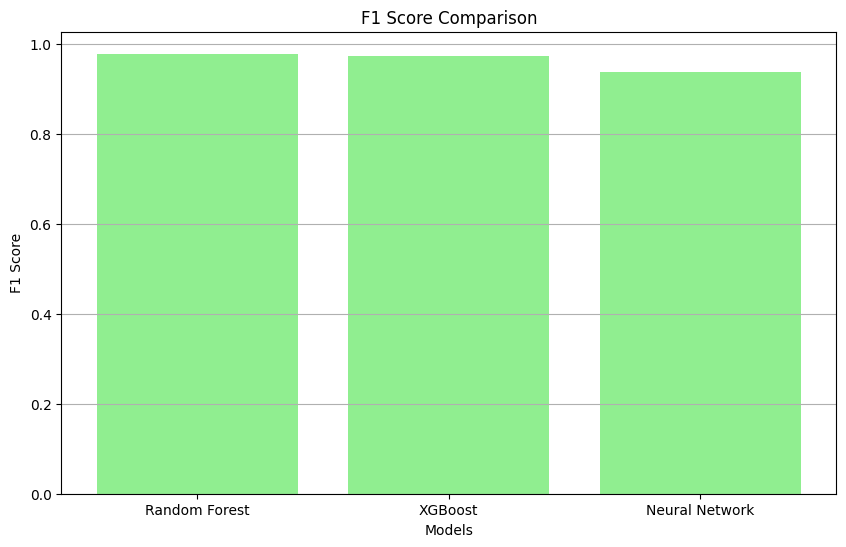

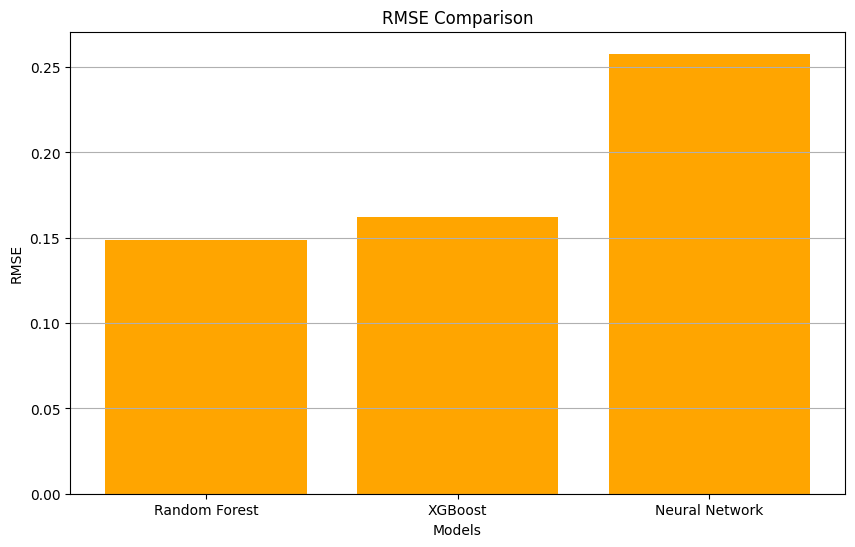

In [9]:
def plot_metric(metrics_df, metric_name, color):
    plt.figure(figsize=(10, 6))
    plt.bar(metrics_df['Model'], metrics_df[metric_name], color=color)
    plt.title(f'{metric_name} Comparison')
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.grid(axis='y')
    plt.show()

plot_metric(metrics_df, 'Precision', 'skyblue')
plot_metric(metrics_df, 'Recall', 'salmon')
plot_metric(metrics_df, 'F1 Score', 'lightgreen')
plot_metric(metrics_df, 'RMSE', 'orange')


<Figure size 1200x800 with 0 Axes>

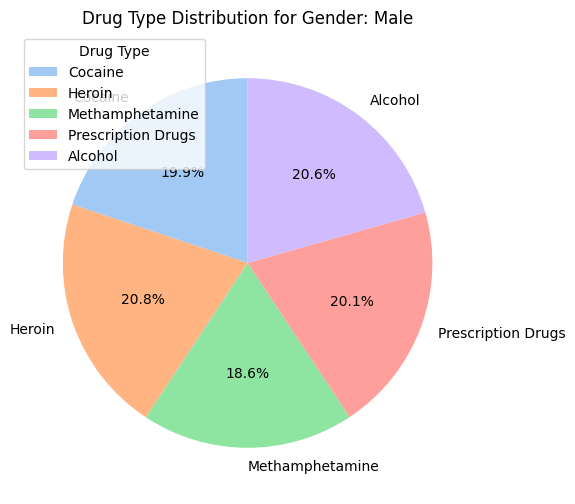

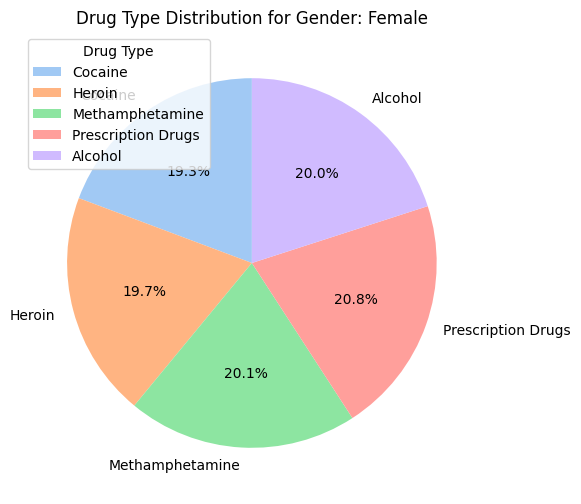

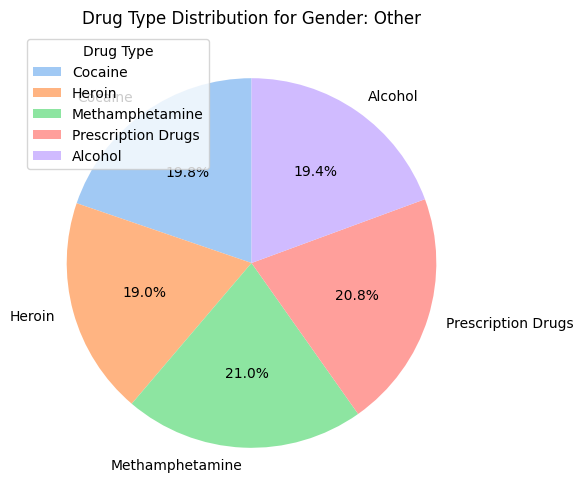

In [10]:
def plot_drug_distribution(df):
    plt.figure(figsize=(12, 8))
    drug_gender_distribution = df.groupby(['Gender', 'Drug_Type']).size().unstack().fillna(0)
    
    # Define custom labels
    drug_labels = {0: 'Cocaine', 1: 'Heroin', 2: 'Methamphetamine', 3: 'Prescription Drugs', 4: 'Alcohol'}
    gender_labels = {0: 'Male', 1: 'Female', 2: 'Other'}
    
    for gender in drug_gender_distribution.index:
        plt.figure(figsize=(10, 6))
        plt.pie(drug_gender_distribution.loc[gender], labels=[drug_labels[i] for i in drug_gender_distribution.columns],
                autopct='%1.1f%%', colors=sns.color_palette("pastel"), startangle=90)
        plt.title(f'Drug Type Distribution for Gender: {gender_labels[gender]}')
        plt.legend(title='Drug Type', loc='upper left', labels=[drug_labels[i] for i in drug_gender_distribution.columns])
        plt.show()

plot_drug_distribution(df)


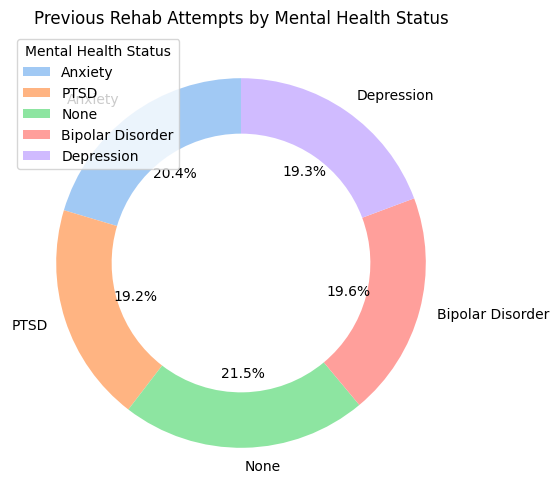

In [11]:
def plot_rehab_distribution(df):
    plt.figure(figsize=(10, 6))
    
    # Aggregating data: count of previous rehab attempts for each mental health status
    rehab_mental_distribution = df.groupby('Mental_Health_Status').size()
    
    # Define custom labels for mental health status
    mental_health_labels = {0: 'Anxiety', 1: 'PTSD', 2: 'None', 3: 'Bipolar Disorder', 4: 'Depression'}
    
    # Use labels and order them to match the data
    labels = [mental_health_labels[i] for i in rehab_mental_distribution.index]
    sizes = rehab_mental_distribution.values
    colors = sns.color_palette("pastel", len(labels))
    
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, wedgeprops=dict(width=0.3), startangle=90)
    plt.title('Previous Rehab Attempts by Mental Health Status')
    plt.legend(title='Mental Health Status', loc='upper left', labels=labels)
    plt.show()

plot_rehab_distribution(df)


In [12]:
!jupyter nbconvert --to script Drug_Analysis.ipynb

[NbConvertApp] Converting notebook Drug_Analysis.ipynb to script
[NbConvertApp] Writing 7181 bytes to Drug_Analysis.py
